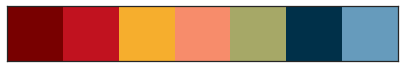

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import glob

sns.set(style="white", font_scale=2.0)
palette = ["#780000", "#C1121F", "#f6ae2d", "#F78C6B", "#A6A867", "#003049", "#669BBC"]
sns.palplot(palette)
sns.set_palette(palette)
# sns.palplot(palette)
# sns.set_palette(palette)

pinned to dirs in /home/wesley_m/conformal-bayesopt/results/

In [2]:
keys = ["rnd", "ei", "nei", "ucb", "cei", "cnei", "cucb"]
labels = {k: kk for k, kk in zip(keys,
                                 [
        "Random", "EI", "NEI", "UCB", "Conformal EI", "Conformal NEI", "Conformal UCB", "KG", "Conformal KG"
                        ])}

# keys = [keys[4], keys[1], keys[5], keys[2], keys[6], keys[3], keys[0]]
keys = [keys[-3], keys[-2], keys[-1], keys[1], keys[2], keys[3], keys[0]]

In [3]:
labels

{'rnd': 'Random',
 'ei': 'EI',
 'nei': 'NEI',
 'ucb': 'UCB',
 'cei': 'Conformal EI',
 'cnei': 'Conformal NEI',
 'cucb': 'Conformal UCB'}

In [4]:
%pdb

Automatic pdb calling has been turned ON


In [5]:
def get_results(prefix):
    results_dict = {k: [] for k in keys}
    for f in glob.glob("../results/"+prefix+"*.pt"):
        try:
            res = torch.load(f, map_location="cpu")
            res2 = res["results"]["best_achieved"]
            for key in keys:
                results_dict[key].append(res2[key])
        except RuntimeError:
            print("unable to load", f)
    return results_dict
        

In [6]:
from scipy.stats import binom

def prep_mean_and_bands(lst, slice_ind=0):
    try:
        tsr = torch.tensor(lst)
    except:
        tsr = torch.stack(lst)#.t()
    if tsr.ndim > 2:
        tsr = tsr[...,slice_ind]
    cummaxes = tsr.cummax(1)[0]
    
    ntrials = cummaxes.shape[0]
    l = torch.arange(ntrials)[binom.cdf(torch.arange(ntrials), ntrials, 0.5) < 0.025][-1]
    u = torch.arange(ntrials)[binom.cdf(torch.arange(ntrials), ntrials, 0.5) > 0.975][0]
    sorted_cvals = cummaxes.sort(0)[0][[l.item(), u.item()]]
    # print(l, u)
    medians = cummaxes.nanmedian(0)[0]
    return medians, sorted_cvals[0], sorted_cvals[1]


In [7]:
!ls ../results/v12/

branincurrin_q3_0.pt   levy5_q3_18.pt	    ro_levy5_q1_5.pt
branincurrin_q3_10.pt  levy5_q3_19.pt	    ro_levy5_q1_6.pt
branincurrin_q3_12.pt  levy5_q3_20.pt	    ro_levy5_q1_7.pt
branincurrin_q3_14.pt  levy5_q3_23.pt	    ro_levy5_q1_8.pt
branincurrin_q3_16.pt  levy5_q3_24.pt	    ro_levy5_q1_9.pt
branincurrin_q3_18.pt  levy5_q3_2.pt	    ro_levy5_q3_0.pt
branincurrin_q3_20.pt  levy5_q3_3.pt	    ro_levy5_q3_10.pt
branincurrin_q3_22.pt  levy5_q3_4.pt	    ro_levy5_q3_11.pt
branincurrin_q3_24.pt  levy5_q3_6.pt	    ro_levy5_q3_12.pt
branincurrin_q3_26.pt  levy5_q3_7.pt	    ro_levy5_q3_13.pt
branincurrin_q3_28.pt  levy5_q3_8.pt	    ro_levy5_q3_14.pt
branincurrin_q3_2.pt   penicillin_q3_11.pt  ro_levy5_q3_15.pt
branincurrin_q3_32.pt  penicillin_q3_13.pt  ro_levy5_q3_16.pt
branincurrin_q3_36.pt  penicillin_q3_15.pt  ro_levy5_q3_17.pt
branincurrin_q3_40.pt  penicillin_q3_17.pt  ro_levy5_q3_18.pt
branincurrin_q3_44.pt  penicillin_q3_19.pt  ro_levy5_q3_19.pt
branincurrin_q3_48.pt  penicillin_q3_1.pt 

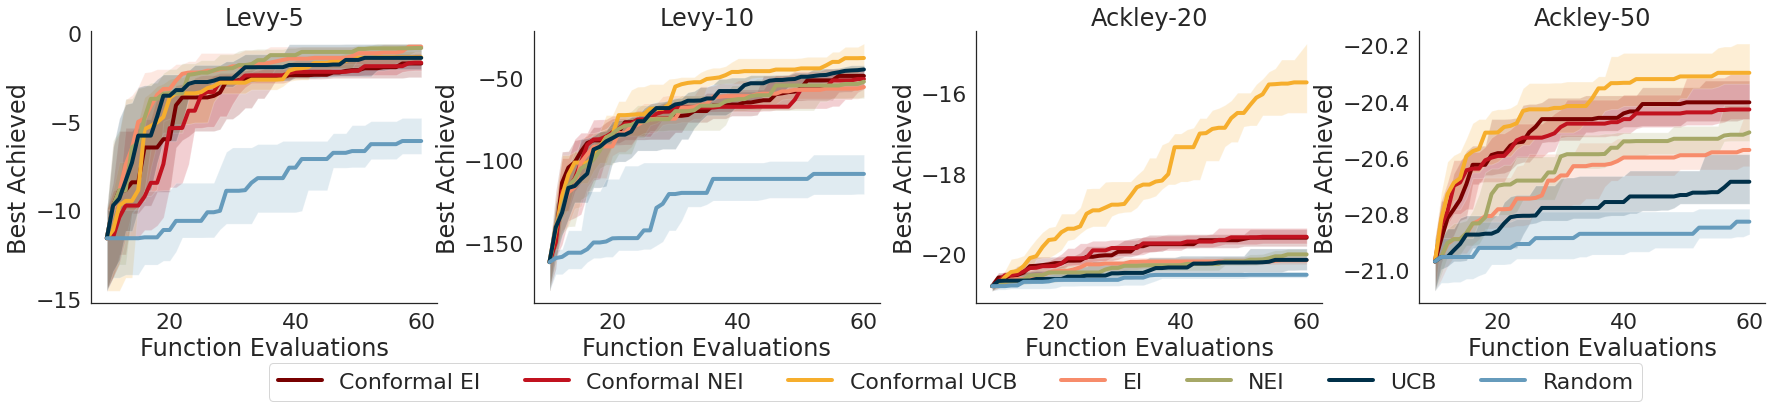

In [8]:
fig, ax = plt.subplots(1, 4, figsize = (30, 5))
# ax = [ax]
# for i, prefix in enumerate(["ro_ackley5_q1", "ro_ackley10_q1", "ro_ackley20_q1", "ro_ackley50_q1"]):
# for i, prefix in enumerate(["v12/ro_levy5_q1", "v12/ro_levy10_q1", "v12/ro_levy20_q1", "v12/ro_levy50_q1"]):
# for i, prefix in enumerate(["v12/levy5_q1", "v12/levy10_q1", "v12/levy20_q1", "v12/levy50_q1"]):
for i, prefix in enumerate(["v12/levy5_q1", "v12/levy20_q1", "ro_ackley20_q1", "ro_ackley50_q1"]):
    results_dict = get_results(prefix)
    x = torch.arange(10, 51 + 10)
    for key in keys:
        ax[i].plot(x, prep_mean_and_bands(results_dict[key])[0], label = labels[key], linewidth=4)
        ax[i].fill_between(x, *prep_mean_and_bands(results_dict[key])[1:], alpha = 0.2)

    # ax[i].set_ylim((-4., 0.2))
    ax[i].set_xlabel("Function Evaluations")
    ax[i].set_ylabel("Best Achieved")
    sns.despine(ax=ax[i])
# ax[0].set_ylim((-30, -10.))
# ax[0].set_ylim((-4., 0.))
# ax[1].set_ylim((-10., -2.))
# ax[2].set_ylim((-60., -12.))
ax[0].legend(ncol = 7, loc = "lower center", bbox_to_anchor = (2.5, -0.4))
# ax[0].legend(ncol = 3, loc = "lower center", bbox_to_anchor = (0.5, -0.5))
# plt.tight_layout()
plt.subplots_adjust(wspace=0.28)

ax[0].set_title("Levy-5")
ax[1].set_title("Levy-10")
ax[2].set_title("Ackley-20")
ax[3].set_title("Ackley-50")

plt.savefig("singleobj_q1.pdf", bbox_inches = "tight")

In [9]:
%pdb

Automatic pdb calling has been turned OFF


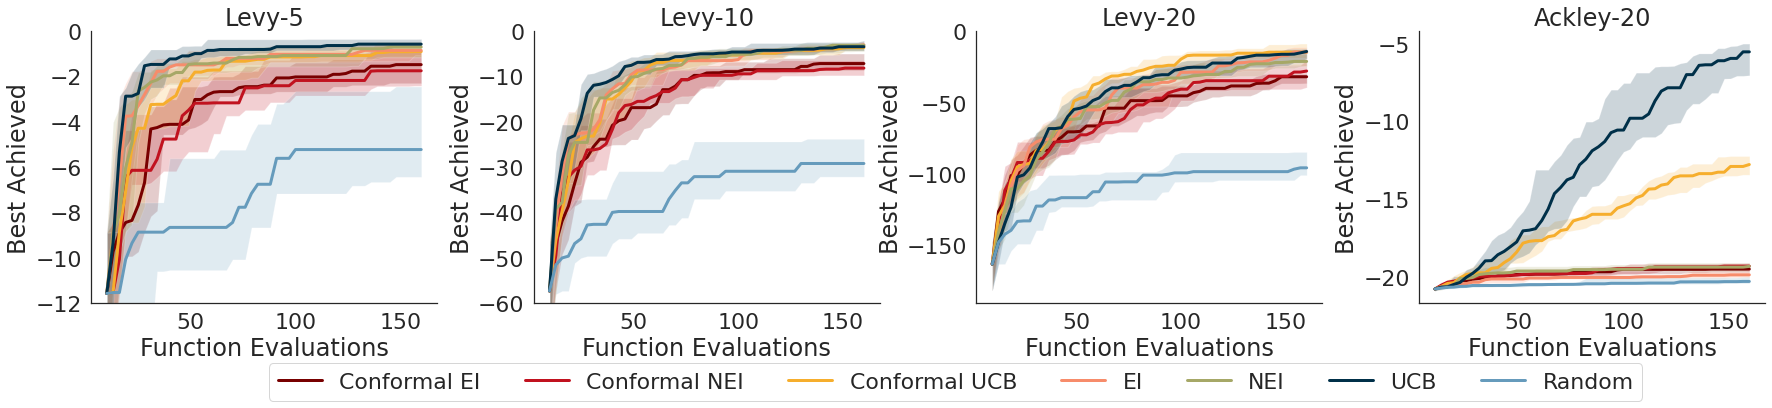

In [10]:
fig, ax = plt.subplots(1, 4, figsize = (30, 5))
# ax = [ax]
x = torch.arange(10, 51 * 3 + 10, 3)
# for i, prefix in enumerate(["v12/levy5_q3", "v12/levy10_q3", "v12/levy20_q3", "v12/levy50_q3"]):
# for i, prefix in enumerate(["v12/ro_levy5_q3", "v12/ro_levy10_q3", "v12/ro_levy20_q3", "v12/ro_levy50_q3"]):
# for i, prefix in enumerate(["ro_ackley5_q3", "ro_ackley10_q3", "ro_ackley20_q3", "ro_ackley50_q3"]):
for i, prefix in enumerate(["v12/levy5_q3", "v12/levy10_q3", "v12/ro_levy20_q3", "ro_ackley20_q3"]):
    results_dict = get_results(prefix)
    for key in keys:
        ax[i].plot(x, prep_mean_and_bands(results_dict[key])[0], label = labels[key], linewidth=3)
        ax[i].fill_between(x, *prep_mean_and_bands(results_dict[key])[1:], alpha = 0.2)

    # ax[i].set_ylim((-4., 0.2))
    ax[i].set_xlabel("Function Evaluations")
    ax[i].set_ylabel("Best Achieved")
    sns.despine(ax = ax[i])
    
# plt.tight_layout()
ax[0].legend(ncol = 8, loc = "lower center", bbox_to_anchor = (2.5, -0.4))
# ax[0].legend(ncol = 3, loc = "lower center", bbox_to_anchor = (0.5, -0.5))

ax[0].set_ylim((-12., 0.))
ax[1].set_ylim((-60, 0.))
ax[0].set_title("Levy-5")
ax[1].set_title("Levy-10")
ax[2].set_title("Levy-20")
ax[3].set_title("Ackley-20")
plt.subplots_adjust(wspace=0.28)
plt.savefig("singleobj_q3.pdf", bbox_inches = "tight")

In [11]:
keys = ["cei", "cnei", "cucb", "ei", "nei", "ucb"]
# keys = keys[:-1]

def get_results(prefix):
    results_dict = {k: [] for k in keys}
    for f in glob.glob("../results/"+prefix+"*.pt"):
        try:
            res = torch.load(f, map_location="cpu")
            res2 = res["results"]["coverage"]
            for key in keys:
                results_dict[key].append(res2[key])
        except RuntimeError:
            print("unable to load ", f)
    return results_dict

def prep_mean_and_bands(lst, slice_ind=0):
    try:
        tsr = torch.tensor(lst)
    except:
        tsr = torch.stack(lst)#.t()
    if tsr.ndim > 2:
        tsr = tsr[...,slice_ind]
    # cummaxes = tsr.cummax(1)[0]
    cummaxes = tsr
    
    ntrials = cummaxes.shape[0]
    l = torch.arange(ntrials)[binom.cdf(torch.arange(ntrials), ntrials, 0.5) < 0.025][-1]
    u = torch.arange(ntrials)[binom.cdf(torch.arange(ntrials), ntrials, 0.5) > 0.975][0]
    sorted_cvals = cummaxes.sort(0)[0][[l.item(), u.item()]]
    # print(l, u)
    medians = cummaxes.nanmedian(0)[0]
    return medians, sorted_cvals[0], sorted_cvals[1]

In [13]:
from scipy.stats import binom

In [14]:
alpha = 1.0 / (0.8 * torch.arange(10, 50 * 1 + 10, 1))**0.5

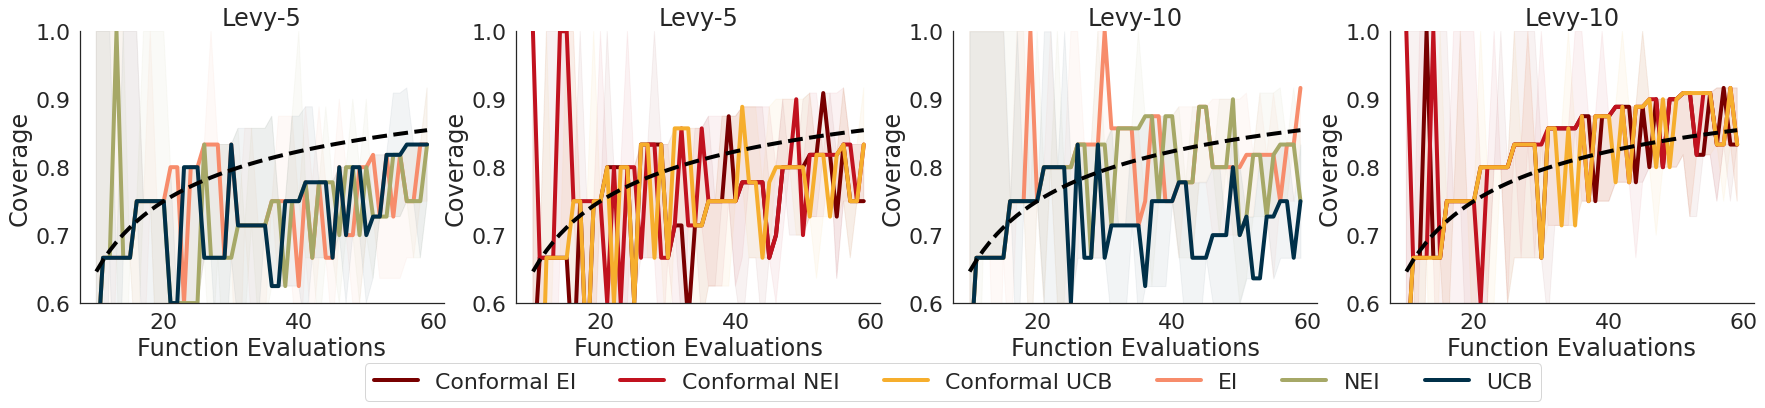

In [17]:
fig, ax = plt.subplots(1, 4, figsize = (30, 5))

# x = torch.arange(10, 50 * 3 + 10, 3)

# for i, prefix in enumerate(["ro_levy5_q1", "ro_levy10_q1", "ro_levy20_q1", "ro_levy50_q1"]):
# for i, prefix in enumerate(["ro_ackley5_q1", "ro_ackley10_q1", "ro_ackley20_q1", "ro_ackley50_q1"]):
# for i, prefix in enumerate(["v12/levy5_q1", "v12/levy20_q1", "ro_ackley20_q1", "ro_ackley50_q1"]):
bayes_keys = ["ei", "nei", "ucb"]
conf_keys = ["cei", "cnei", "cucb"]
bayes_cols = palette[3:6]
conf_cols = palette[0:3]

for j, key in enumerate(conf_keys):
    ax[2].plot([], [], color=conf_cols[j], label=labels[key], linewidth=4)
    
for i, prefix in enumerate(["v12/levy5_q1", "v12/levy5_q1", "v12/levy20_q1", "v12/levy20_q1"]):
    results_dict = get_results(prefix)
    x = torch.arange(10, 50 + 10)
    ax[i].plot(x, 1 - alpha, color = "black", linestyle="--", zorder=10, linewidth = 4)
    
    if i % 2 == 0:
        _keys = bayes_keys
        slice_ind = 0
        cols = bayes_cols
    else:
        _keys = conf_keys
        slice_ind = 1
        cols = conf_cols
    
    for j, key in enumerate(_keys):
        ax[i].plot(x, prep_mean_and_bands(results_dict[key], slice_ind)[0], 
                   label = labels[key], linewidth=4, color = cols[j])
        ax[i].fill_between(x, *prep_mean_and_bands(results_dict[key], slice_ind)[1:], alpha = 0.05,
                          color=cols[j])         

    # ax[i].set_ylim((-4., 0.2))
    ax[i].set_xlabel("Function Evaluations")
    ax[i].set_ylabel("Coverage")
    # ax[i].set_ylim((0.5, 1.0))
    sns.despine(ax=ax[i])
    ax[i].set_ylim((0.6, 1.0))
# ax[2].set_ylim((-15, -1.))
# plt.tight_layout()
ax[2].legend(ncol = 7, loc = "lower center", bbox_to_anchor = (-0.0, -0.4))

ax[0].set_title("Levy-5")
ax[1].set_title("Levy-5")
ax[2].set_title("Levy-10")
ax[3].set_title("Levy-10")
plt.savefig("levy_coverage_q1.pdf", bbox_inches = "tight")

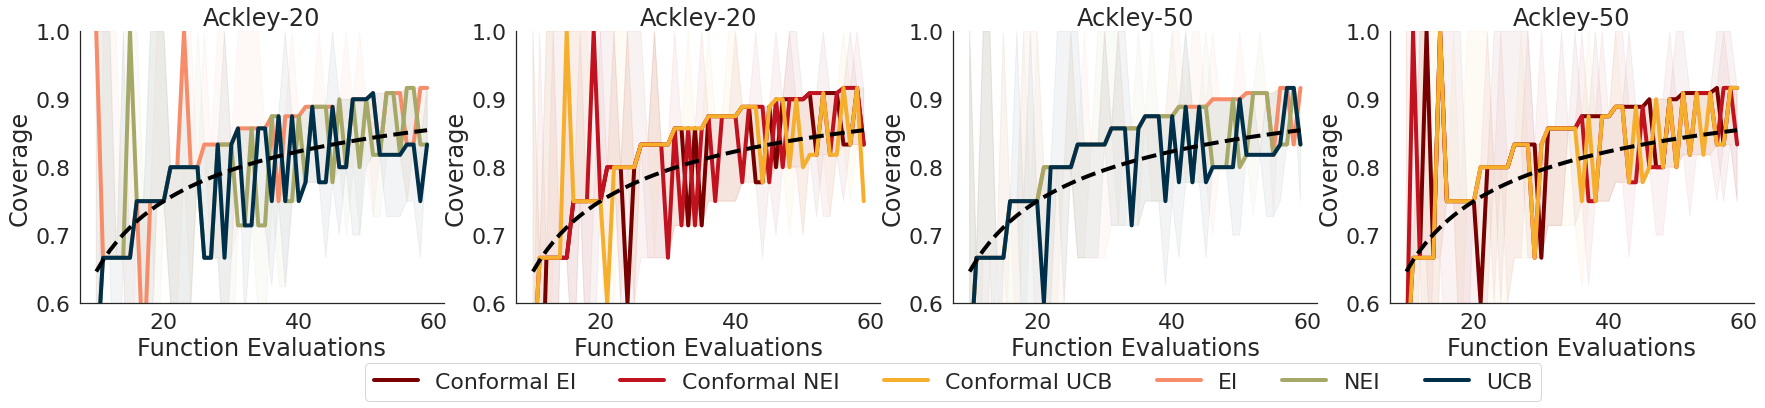

In [18]:
fig, ax = plt.subplots(1, 4, figsize = (30, 5))

# x = torch.arange(10, 50 * 3 + 10, 3)

# for i, prefix in enumerate(["ro_levy5_q1", "ro_levy10_q1", "ro_levy20_q1", "ro_levy50_q1"]):
# for i, prefix in enumerate(["ro_ackley5_q1", "ro_ackley10_q1", "ro_ackley20_q1", "ro_ackley50_q1"]):
# for i, prefix in enumerate(["v12/levy5_q1", "v12/levy20_q1", "ro_ackley20_q1", "ro_ackley50_q1"]):
bayes_keys = ["ei", "nei", "ucb"]
conf_keys = ["cei", "cnei", "cucb"]
bayes_cols = palette[3:6]
conf_cols = palette[0:3]

for j, key in enumerate(conf_keys):
    ax[2].plot([], [], color=conf_cols[j], label=labels[key], linewidth=4)
    
for i, prefix in enumerate(["ro_ackley20_q1", "ro_ackley20_q1", "ro_ackley50_q1", "ro_ackley50_q1"]):
    results_dict = get_results(prefix)
    x = torch.arange(10, 50 + 10)
    ax[i].plot(x, 1 - alpha, color = "black", linestyle="--", zorder=10, linewidth = 4)
    
    if i % 2 == 0:
        _keys = bayes_keys
        slice_ind = 0
        cols = bayes_cols
    else:
        _keys = conf_keys
        slice_ind = 1
        cols = conf_cols
    
    for j, key in enumerate(_keys):
        ax[i].plot(x, prep_mean_and_bands(results_dict[key], slice_ind)[0], 
                   label = labels[key], linewidth=4, color = cols[j])
        ax[i].fill_between(x, *prep_mean_and_bands(results_dict[key], slice_ind)[1:], alpha = 0.05,
                          color=cols[j])         

    # ax[i].set_ylim((-4., 0.2))
    ax[i].set_xlabel("Function Evaluations")
    ax[i].set_ylabel("Coverage")
    # ax[i].set_ylim((0.5, 1.0))
    sns.despine(ax=ax[i])
    ax[i].set_ylim((0.6, 1.0))
# ax[2].set_ylim((-15, -1.))
# plt.tight_layout()
ax[2].legend(ncol = 7, loc = "lower center", bbox_to_anchor = (-0.0, -0.4))

ax[0].set_title("Ackley-20")
ax[1].set_title("Ackley-20")
ax[2].set_title("Ackley-50")
ax[3].set_title("Ackley-50")
plt.savefig("ackley_coverage_q1.pdf", bbox_inches = "tight")

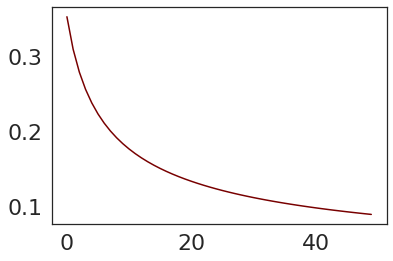

In [19]:
alpha = 1.0 / (0.8 * torch.arange(10, 50 * 3 + 10, 3))**0.5

plt.plot(alpha)

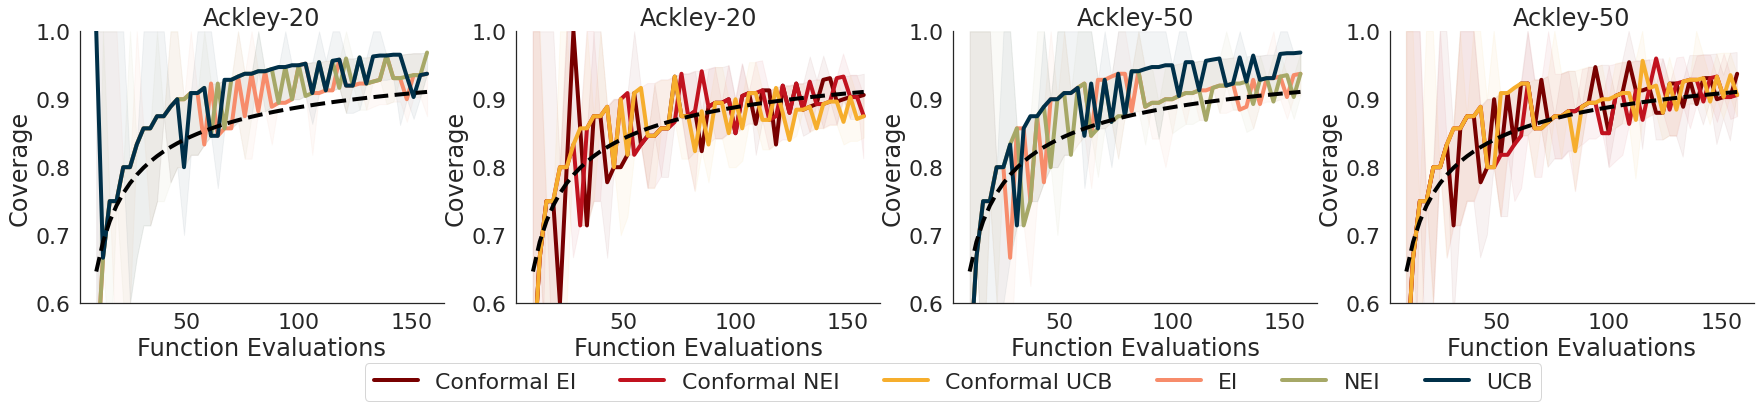

In [20]:
fig, ax = plt.subplots(1, 4, figsize = (30, 5))

# x = torch.arange(10, 50 * 3 + 10, 3)

# for i, prefix in enumerate(["ro_levy5_q1", "ro_levy10_q1", "ro_levy20_q1", "ro_levy50_q1"]):
# for i, prefix in enumerate(["ro_ackley5_q1", "ro_ackley10_q1", "ro_ackley20_q1", "ro_ackley50_q1"]):
# for i, prefix in enumerate(["v12/levy5_q1", "v12/levy20_q1", "ro_ackley20_q1", "ro_ackley50_q1"]):
bayes_keys = ["ei", "nei", "ucb"]
conf_keys = ["cei", "cnei", "cucb"]
bayes_cols = palette[3:6]
conf_cols = palette[0:3]

for j, key in enumerate(conf_keys):
    ax[2].plot([], [], color=cols[j], label=labels[key], linewidth=4)
    
for i, prefix in enumerate(["ro_ackley20_q3", "ro_ackley20_q3", "ro_ackley50_q3", "ro_ackley50_q3"]):
    results_dict = get_results(prefix)
    x = torch.arange(10, 50*3 + 10, 3)
    ax[i].plot(x, 1 - alpha, color = "black", linestyle="--", zorder=10, linewidth = 4)
    
    if i % 2 == 0:
        _keys = bayes_keys
        slice_ind = 0
        cols = bayes_cols
    else:
        _keys = conf_keys
        slice_ind = 1
        cols = conf_cols
    
    for j, key in enumerate(_keys):
        ax[i].plot(x, prep_mean_and_bands(results_dict[key], slice_ind)[0], 
                   label = labels[key], linewidth=4, color = cols[j])
        ax[i].fill_between(x, *prep_mean_and_bands(results_dict[key], slice_ind)[1:], alpha = 0.05,
                          color=cols[j])         

    # ax[i].set_ylim((-4., 0.2))
    ax[i].set_xlabel("Function Evaluations")
    ax[i].set_ylabel("Coverage")
    # ax[i].set_ylim((0.5, 1.0))
    sns.despine(ax=ax[i])
    ax[i].set_ylim((0.6, 1.0))
# ax[2].set_ylim((-15, -1.))
# plt.tight_layout()
ax[2].legend(ncol = 7, loc = "lower center", bbox_to_anchor = (-0.0, -0.4))

ax[0].set_title("Ackley-20")
ax[1].set_title("Ackley-20")
ax[2].set_title("Ackley-50")
ax[3].set_title("Ackley-50")
plt.savefig("ackley_coverages_q3.pdf", bbox_inches = "tight")

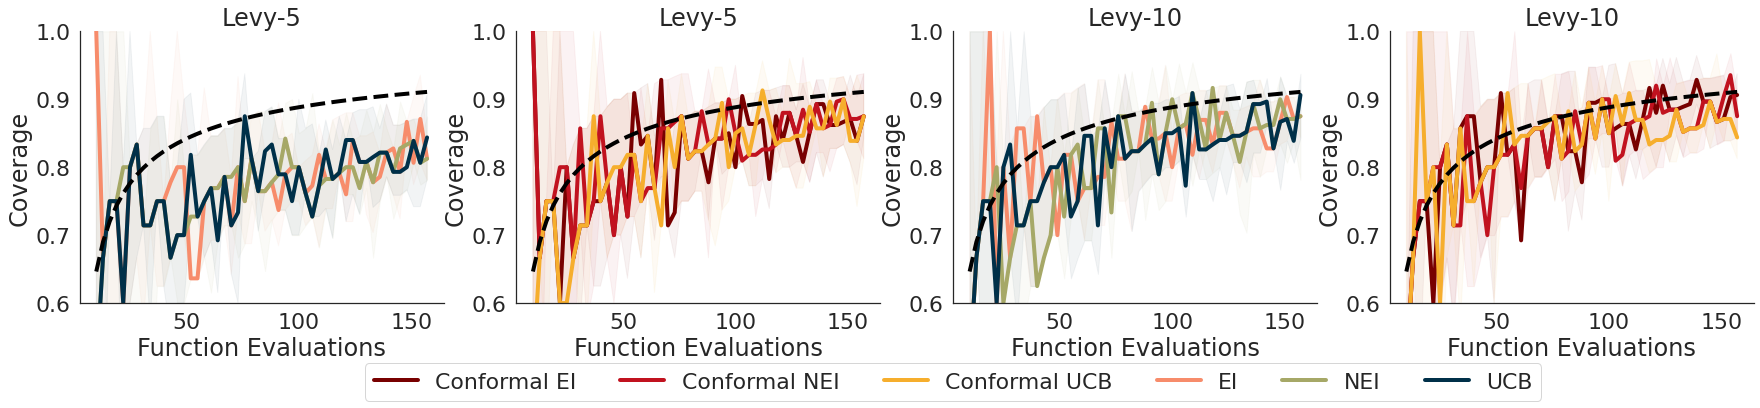

In [21]:
fig, ax = plt.subplots(1, 4, figsize = (30, 5))

# x = torch.arange(10, 50 * 3 + 10, 3)

# for i, prefix in enumerate(["ro_levy5_q1", "ro_levy10_q1", "ro_levy20_q1", "ro_levy50_q1"]):
# for i, prefix in enumerate(["ro_ackley5_q1", "ro_ackley10_q1", "ro_ackley20_q1", "ro_ackley50_q1"]):
# for i, prefix in enumerate(["v12/levy5_q1", "v12/levy20_q1", "ro_ackley20_q1", "ro_ackley50_q1"]):
bayes_keys = ["ei", "nei", "ucb"]
conf_keys = ["cei", "cnei", "cucb"]
bayes_cols = palette[3:6]
conf_cols = palette[0:3]

for j, key in enumerate(conf_keys):
    ax[2].plot([], [], color=cols[j], label=labels[key], linewidth=4)
    
for i, prefix in enumerate(["v12/levy5_q3", "v12/levy5_q3", "v12/levy10_q3", "v12/levy10_q3"]):
    results_dict = get_results(prefix)
    x = torch.arange(10, 50*3 + 10, 3)
    ax[i].plot(x, 1 - alpha, color = "black", linestyle="--", zorder=10, linewidth = 4)
    
    if i % 2 == 0:
        _keys = bayes_keys
        slice_ind = 0
        cols = bayes_cols
    else:
        _keys = conf_keys
        slice_ind = 1
        cols = conf_cols
    
    for j, key in enumerate(_keys):
        ax[i].plot(x, prep_mean_and_bands(results_dict[key], slice_ind)[0], 
                   label = labels[key], linewidth=4, color = cols[j])
        ax[i].fill_between(x, *prep_mean_and_bands(results_dict[key], slice_ind)[1:], alpha = 0.05,
                          color=cols[j])         

    # ax[i].set_ylim((-4., 0.2))
    ax[i].set_xlabel("Function Evaluations")
    ax[i].set_ylabel("Coverage")
    # ax[i].set_ylim((0.5, 1.0))
    sns.despine(ax=ax[i])
    ax[i].set_ylim((0.6, 1.0))
# ax[2].set_ylim((-15, -1.))
# plt.tight_layout()
ax[2].legend(ncol = 7, loc = "lower center", bbox_to_anchor = (-0.0, -0.4))

ax[0].set_title("Levy-5")
ax[1].set_title("Levy-5")
ax[2].set_title("Levy-10")
ax[3].set_title("Levy-10")
plt.savefig("levy_coverages_q3.pdf", bbox_inches = "tight")

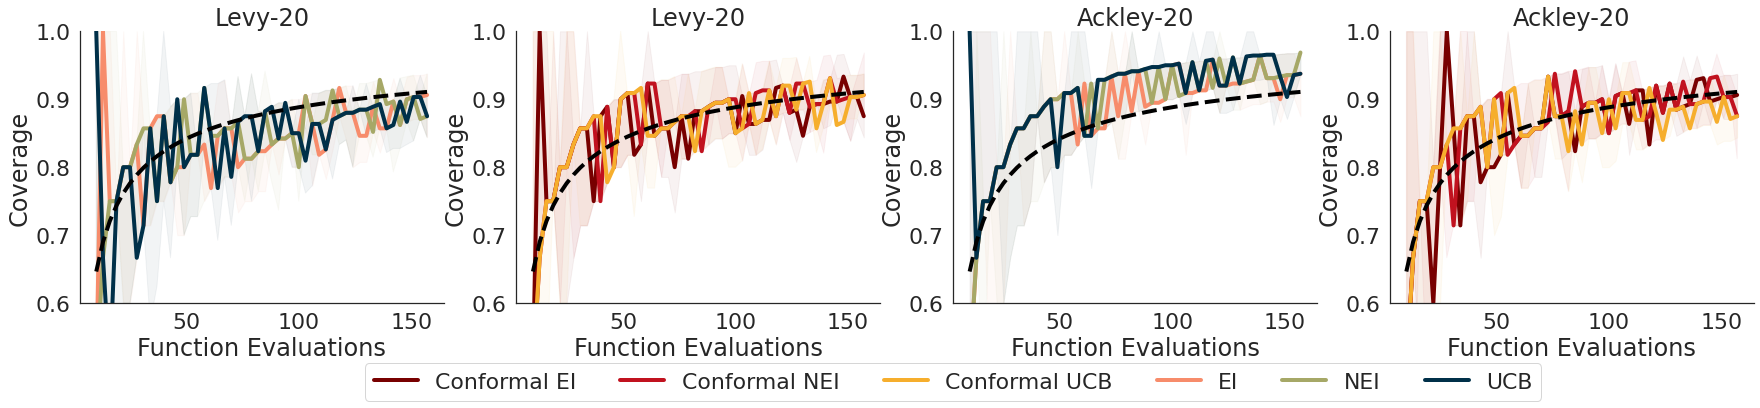

In [22]:
fig, ax = plt.subplots(1, 4, figsize = (30, 5))

# x = torch.arange(10, 50 * 3 + 10, 3)

# for i, prefix in enumerate(["ro_levy5_q1", "ro_levy10_q1", "ro_levy20_q1", "ro_levy50_q1"]):
# for i, prefix in enumerate(["ro_ackley5_q1", "ro_ackley10_q1", "ro_ackley20_q1", "ro_ackley50_q1"]):
# for i, prefix in enumerate(["v12/levy5_q1", "v12/levy20_q1", "ro_ackley20_q1", "ro_ackley50_q1"]):
bayes_keys = ["ei", "nei", "ucb"]
conf_keys = ["cei", "cnei", "cucb"]
bayes_cols = palette[3:6]
conf_cols = palette[0:3]

for j, key in enumerate(conf_keys):
    ax[2].plot([], [], color=cols[j], label=labels[key], linewidth=4)
    
for i, prefix in enumerate(["v12/ro_levy20_q3", "v12/ro_levy20_q3", "ro_ackley20_q3", "ro_ackley20_q3"]):
    results_dict = get_results(prefix)
    x = torch.arange(10, 50*3 + 10, 3)
    ax[i].plot(x, 1 - alpha, color = "black", linestyle="--", zorder=10, linewidth = 4)
    
    if i % 2 == 0:
        _keys = bayes_keys
        slice_ind = 0
        cols = bayes_cols
    else:
        _keys = conf_keys
        slice_ind = 1
        cols = conf_cols
    
    for j, key in enumerate(_keys):
        ax[i].plot(x, prep_mean_and_bands(results_dict[key], slice_ind)[0], 
                   label = labels[key], linewidth=4, color = cols[j])
        ax[i].fill_between(x, *prep_mean_and_bands(results_dict[key], slice_ind)[1:], alpha = 0.05,
                          color=cols[j])         

    # ax[i].set_ylim((-4., 0.2))
    ax[i].set_xlabel("Function Evaluations")
    ax[i].set_ylabel("Coverage")
    # ax[i].set_ylim((0.5, 1.0))
    sns.despine(ax=ax[i])
    ax[i].set_ylim((0.6, 1.0))
# ax[2].set_ylim((-15, -1.))
# plt.tight_layout()
ax[2].legend(ncol = 7, loc = "lower center", bbox_to_anchor = (-0.0, -0.4))

ax[0].set_title("Levy-20")
ax[1].set_title("Levy-20")
ax[2].set_title("Ackley-20")
ax[3].set_title("Ackley-20")
plt.savefig("mixed_coverages_q3.pdf", bbox_inches = "tight")